In [ ]:
import os
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))

if project_root not in sys.path:
    sys.path.append(project_root)

In [19]:
from matplotlib.image import imread
import matplotlib.pyplot as plt
import torch
from sklearn.mixture import GaussianMixture
import joblib
import numpy as np
from models import cmgn, icgn, icnn, mmgn
from trainers import trainer_ot

## Color domain adaptation

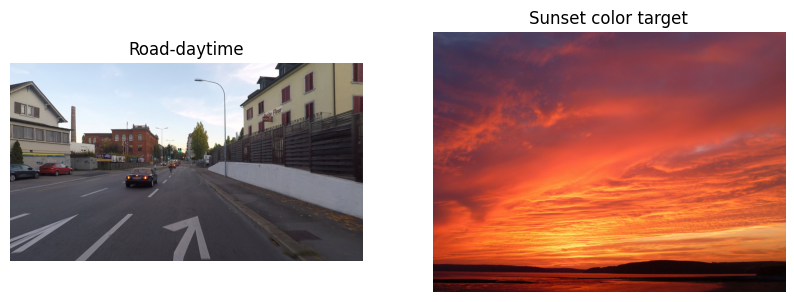

In [10]:
road_path = os.path.join(os.path.dirname(os.getcwd()), 'data', 'road.png')
sunset_path = os.path.join(os.path.dirname(os.getcwd()), 'data', 'sunset.jpeg')

image_source = imread(road_path)
image_target = imread(sunset_path)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image_source)
ax[0].set_title('Road-daytime')
ax[1].imshow(image_target)
ax[1].set_title('Sunset color target')
for a in ax:
    a.axis('off')
plt.show()

We first do Multivariate Gaussian fit for target mean and covariance 
- Target image is sunset
- Road daytime is the the source one

In [68]:
# Fit multivariate gaussian on sunset colors
gmm_path = 'gmm/fitted_gmm_1.joblib'
if not os.path.exists(gmm_path):
    pixels = image_target.reshape(-1, 3)

    idx = np.random.randint(pixels.shape[0], size=20000)
    pixels_sampled = pixels[idx]

    num_components = 10 # Number of Gaussian components
    gmm = GaussianMixture(n_components=num_components, random_state=42, max_iter = 100)
    gmm.fit(pixels_sampled)
else:
    gmm = joblib.load(gmm_path)

In [69]:
mean_sunset = torch.Tensor(gmm.means_) 
covariances_sunset = torch.Tensor(gmm.covariances_) 
print(mean_sunset)

tensor([[171.0564,  67.3806,  61.6970],
        [ 86.0742,  55.9765,  80.1500],
        [249.9144, 167.5224,  70.9062],
        [ 24.1899,   7.7705,   9.5932],
        [251.9275, 121.7524,  56.1696],
        [188.8380,  77.0234,  59.6268],
        [128.6091,  63.0339,  76.6742],
        [108.2339,  23.9986,  14.8694],
        [228.2268, 125.5624,  64.0223],
        [219.9556,  87.8079,  48.2405]])


In [70]:
def kl_divergence_gmm(mu2, sigma2,mean_sunset,covariance_sunset, k = 3):
    kl_array = torch.zeros(mean_sunset.shape[0])
    sigma2_inv = torch.linalg.inv(sigma2)
    for i in range(mean_sunset.shape[0]):
      mu1 = mean_sunset[i]
      sigma1 = covariance_sunset[i]

      kl = 0.5 * (torch.trace(sigma2_inv @ sigma1) +
                  (mu2 - mu1).T @ sigma2_inv @ (mu2 - mu1) -
                  k +
                  torch.log(torch.linalg.det(sigma2) / torch.linalg.det(sigma1)))
      kl_array[i] = kl

    return torch.min(kl_array)

In [71]:
def visualize_color_transport(mod,img,pix,viz=False):
    #mod.eval()
    transported_image = mod(pix).detach().reshape(img.shape)
    if viz:
        fig, ax = plt.subplots(1, 3, figsize=(12, 6))
        # Original image
        ax[0].imshow(img)
        ax[0].set_title('Original Image')
        ax[0].axis('off')

        # Transported image
        ax[1].imshow(transported_image)
        ax[1].set_title('Transported Colors')
        ax[1].axis('off')

        # Target colors
        ax[2].imshow(image_target)
        ax[2].set_title('Target colors')
        ax[2].axis('off')
        plt.show()
    return mod(pix).reshape(img.shape)

In [72]:
def train_color_GMM(mod, img, pix, target_mean,target_covariance,lr=0.02,num_epochs=50000, batch_size=100, viz=False):  
  optimizer = torch.optim.Adam(mod.parameters(), lr=lr)
  losses = []
  history = [] 
  for i in range(num_epochs):
      mod.train()
      idx = np.random.randint(pix.shape[0], size=batch_size)
      pixels_sampled = torch.Tensor(pix[idx]) 

      optimizer.zero_grad()
      output = mod(pixels_sampled)
      output_mean = torch.mean(output, dim=0)
      output_covariance_matrix = torch.matmul((output - output_mean).transpose(0, 1), (output - output_mean)) / batch_size

      loss = kl_divergence_gmm(output_mean,output_covariance_matrix,target_mean, target_covariance)
      loss.backward()
      losses.append(loss.item())
      optimizer.step()
      if not i % (num_epochs//10): 
          # visualize loss
          print("epoch", i, "loss", loss.item())
          # visualize learning of the generator 
          history.append(visualize_color_transport(mod,img,torch.Tensor(pix),viz=viz))

  plt.plot(losses)
  plt.title('Loss')
  plt.show()
  return history, loss.item()

In [73]:
# Training settings
np.random.seed(1234)
epochs = 1000
lr = 1e-3
batch_size = 100
plot_interval = 100
input_dim = 3
output_dim = 3

model_CMGN = cmgn.C_MGN(input_dim=input_dim, hidden_dim=4, num_layers=4, output_dim=output_dim)
optimizer = torch.optim.Adam(model_CMGN.parameters(), lr=lr)

epoch 0 loss 186.8179473876953


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.3349605..19.878088].


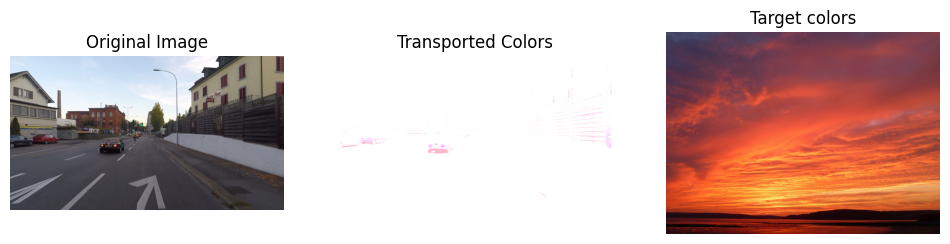

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9976203..39.02343].


epoch 100 loss 17.071882247924805


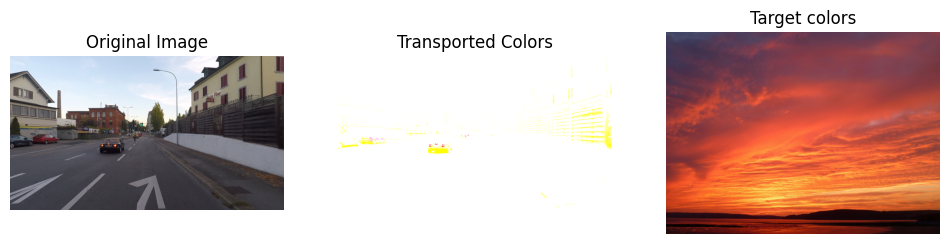

epoch 200 loss 5.617390155792236


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.9303472..48.547417].


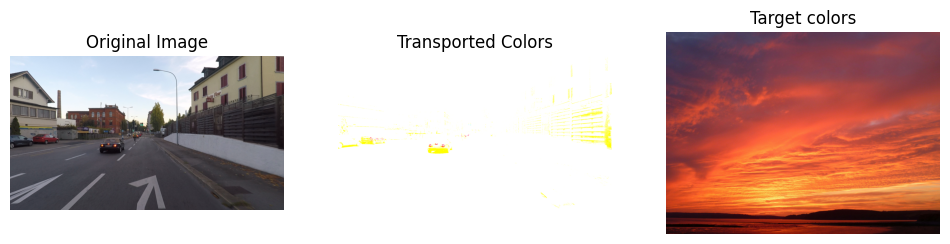

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.9132266..55.133213].


epoch 300 loss 3.373389720916748


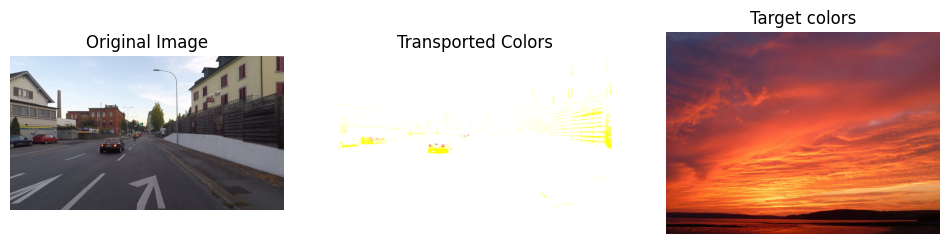

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6.1391764..60.04697].


epoch 400 loss 2.5317180156707764


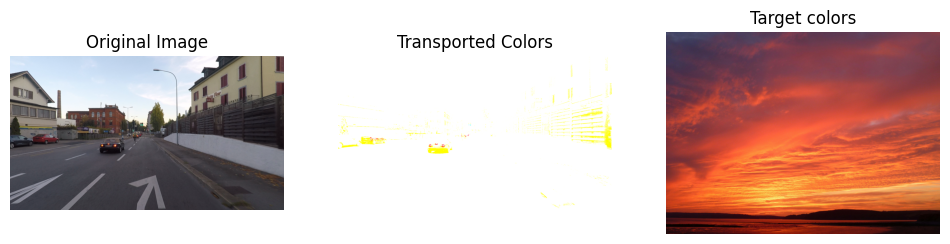

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-7.567319..64.43064].


epoch 500 loss 1.8525854349136353


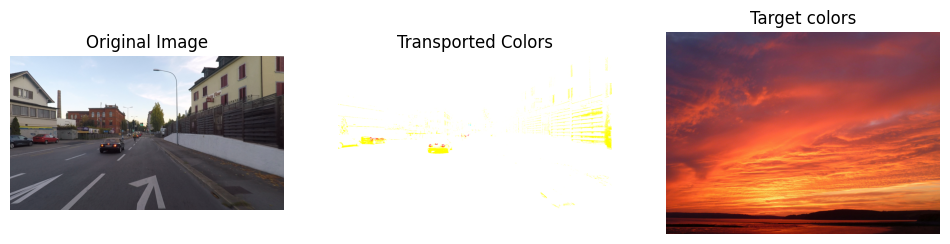

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-9.273705..67.475].


epoch 600 loss 0.9444094896316528


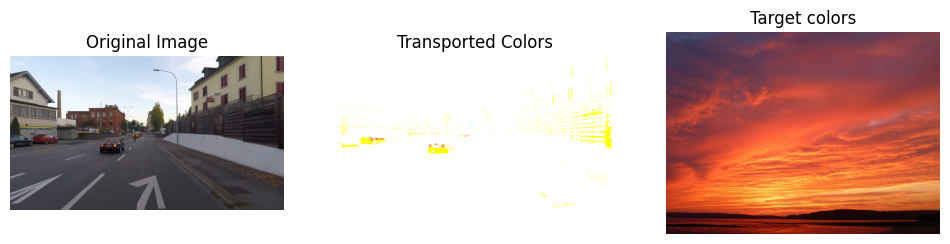

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-10.81859..70.34107].


epoch 700 loss 0.626624345779419


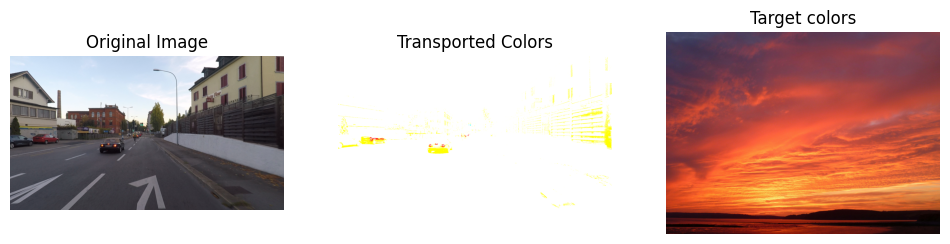

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-12.264233..72.88587].


epoch 800 loss 0.4751037359237671


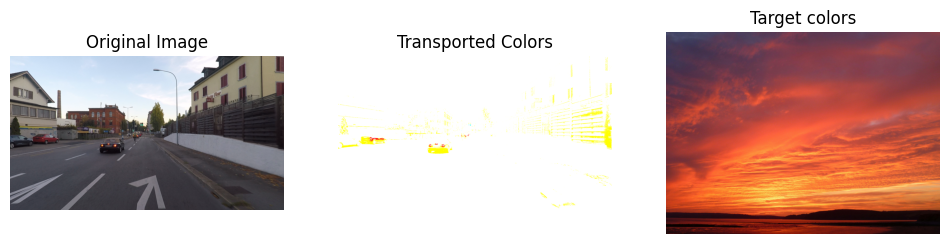

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-13.686125..74.90852].


epoch 900 loss 0.3944584131240845


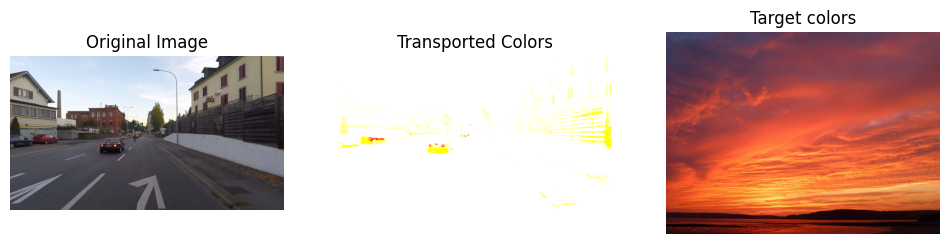

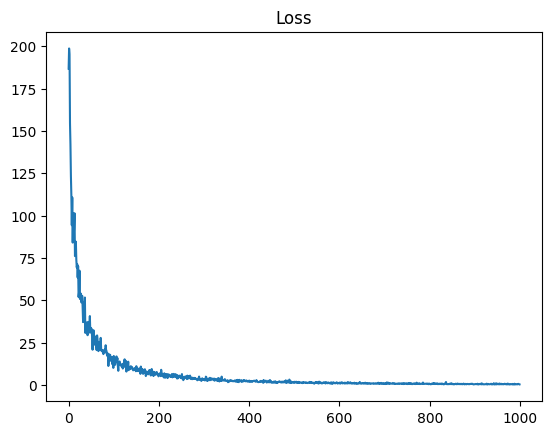

In [84]:
history_gmm, nll_gmm =train_color_GMM(model_CMGN, 
                                      image_source, 
                                      image_source.reshape(-1,3), 
                                      mean_sunset, 
                                      covariances_sunset,
                                      lr=0.02,
                                      num_epochs=epochs,
                                      batch_size=batch_size,
                                      viz=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.150447..6.4652905].


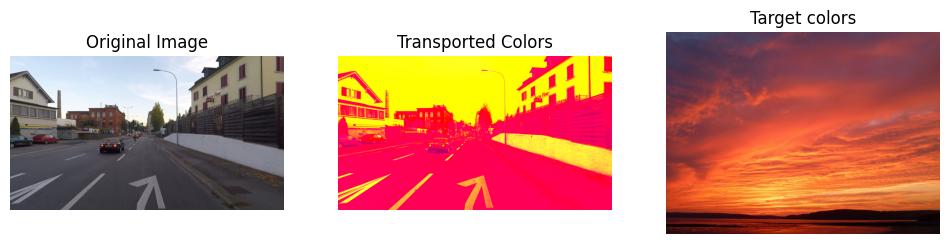

In [60]:
_= visualize_color_transport(model_CMGN,
                             image_source,
                             torch.Tensor(image_source.reshape(-1,3)), 
                             viz=True)